# Optical Spectra with fastBSE
**by <span style="color:darkgreen">Benedikt Maurer</span> for [<span style="color:DarkGoldenRod">exciting *neon*</span>](http://exciting.wikidot.com/neon)**

<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how calculate the absorption spectrum of diamond on using **fastBSE** within exciting.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Preparation](#0)
    
[1. Introduction](#1)
    
[2. Introduction](#1)
        
[3. Calculations](#2)
    
[3.1 Groundstate and Screening](#2.1)
    
[3.2 Direct BSE](#2.2)
    
[3.3 fastBSE](#2.3)
    
[4. Compare the results](#3)
    

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Preparation</span>

**<span style="color:firebrick">Read the following paragraph before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **exciting**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** 

- All input parameters that will appear will be given in **atomic units**!
- For running **fastBSE** calculations, you need to link exciting to **HDF5** and **FFTW3**


<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Introduction</span>

In this tutorial you will learn how to calculate the optical absorption spectrum of with the **fastBSE** algorithm. To demonstrate that the results of the new method are equivalent to the old one, you will also calculate the spectrum with the **direct** algorithm.  If you are not familiar how this is done, begin with the tutorial [<span style="color:firebrick">Excited states from BSE</span>](http://exciting.wikidot.com/oxygen-excited-states-from-bse).

**fastBSE** is low scaling, matrix-free, iterative algorithm to solve the Bethe-Salpeter equation (**BSE**). It scales with $\mathcal O(N_v N_c(1  + \log N_k))$. This is massive speed up compared to the **direct** algorithm that scales with $\mathcal O(N_v^3 N_c^3 N_k^3)$.

The **fastBSE** algorithm was published by  [Henneke and collegues](https://msp.org/camcos/2020/15-1/p04.xhtml).

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Theory</span>

In this tutorial, we only consider the **Tamm-Dancoff-approximation** (**TDA**) and neglect the coupling between the resonant and anti-resonant components of the **Bethe-Salpeter Hamiltonian** (**BSH**). We also neglect finite momentum transitions such that $\mathbf q = \mathbf 0$.

The heavy lifting of solving the **BSE** is setting up and diagonalizing the **BSH**: 

$$
H^{BSE} = D + 2 V - W,
$$

where $D$ is the diagonal part, taking into account the single electron properties, $V$ is the repulsive, long-range exchange interaction and $W$ the attractive screened interaction.
For mapping the problem to linear algebra, we expand the exciton wave function in the two particle basis:

$$
\Phi^\lambda(\mathbf r, \mathbf r') = \sum_{vck} C^\lambda_{vck} \psi_{vk}(\mathbf r)\psi^*_{ck}(\mathbf r'),
$$

where $\psi_{ik}(\mathbf r)$ is a single electron wave function of band $i$, at $\mathbf r$ and the  $k$'th Brillouin zone (BZ) vector. The indices $v$ and $c$ refer to valence and conduction bands, respectively, and $\lambda$ is the index of the exciton. Thus the diagonalization can be rewritten as the following eigenvalue problem:

$$
H^{BSE}|\Phi_\lambda\rangle = E^\lambda |\Phi_\lambda\rangle,
$$

In this expansion the diagonal part is given by

$$
D_{vck, v'c'k'} = \big(\epsilon_{ck} - \epsilon_{vk}\big) \delta_{cc'} \delta_{vv'} \delta_{kk'},
$$

the exchange interaction kernel by

$$
V_{vck, v'c'k'} = \int d^3r \int d^3 r' \frac{ u^*_{v'k'}(\mathbf r')u_{c'k'}(\mathbf r')u^*_{ck}(\mathbf r)u_{vk}(\mathbf r) } {| \mathbf{r - r'} |},
$$

and the screened interaction kernel by

$$
W_{vck, v'c'k'} = \int d^3r \int d^3 r' u^*_{v'k'}(\mathbf r')u_{vk}(\mathbf r') W(\mathbf{r, r'})_{\mathbf {k-k'}} u^*_{ck}(\mathbf r)u_{c'k'}(\mathbf r).
$$

Here was taken into account that for periodic materials, the wavefunctions are Blochwaves and can be written as

$$
\psi_{ik}(\mathbf r) = u_{ik}(\mathbf r) \cdot e^{i\mathbf r \mathbf k},
$$

where $u_{ik}(\mathbf r)$ is the periodic part of the wavefunctions.

In total this results in a matrix with $(N_v N_c N_k)^2$ elements. Solving the **BSE** **directly** means to calculate the full matrix and diagonalizing it. This scales with $\mathcal O\big((N_v N_c N_k)^3\big)$. For many problems, a converged solution of the **BSE** can not be calculated with reasonable resources.

The **fastBSE** algorithm avoids to calculate the full matrix by using **interpolative seperable density fitting** (**ISDF**) for approximating the wavefunction products as $u_{ik}(\mathbf r)u^*_{jk}(\mathbf r)$ in the formulars for the integrals: 

$$
u_{ik}^*(\mathbf r)u_{jk'}(\mathbf r) \approx \sum_{\mu=1}^{N_\mu} \zeta_\mu(\mathbf r) u_{ik}^*(\mathbf r_\mu) u_{jk}(\mathbf r_\mu).
$$

When discretized on a real space grid, $\{\mathbf r_i\}_{i=1}^{N_r}$, $u_{ik}^*(\mathbf r)u_{jk'}(\mathbf r)$ can be viewed as a matrix $Z \in \mathbb C^{N_r \times N_iN_jN_k^2}$, where $N_i$ and $N_j$ are the number of bands of $u_{ik}$ and $u_{jk'}$, respectively, to be combined. Thus, for a given $\mathbf r$ $u_{ik}(\mathbf r)^*u_{jk}(\mathbf r)$ can be viewed as a row vector of size $N_iN_jN_k^2$. The ISDF expands all such rows approximately in a linear combination of matrix rows with respect to a selected set of rows or interpolation points 
and then interpolated on a sub grid $\{\mathbf r_\mu\}_{\mu=1}^{N_\mu} \subseteq \{\mathbf r_i\}_{i=1}^{N_r}$ with typically $N_\mu \ll N_r$. Similarly we can combine the interpolation coeffiecients $\zeta_\mu(\mathbf r)$ in a matrix $\Theta \in \mathbb C^{N_r \times N_\mu}$ and the interpolation rows $u_{ik}(\mathbf r)u_{jk'}(\mathbf r)$ in a matrix $C \in \mathbb C^{N_\mu \times N_iN_jN_k^2}$. Using linear algebra notation, we can write the approximation as
 
$$
Z \approx \Theta C.
$$

With respect to the interpolation coefficients $\Theta$ this equation is an over-determined linear system and can be solved by the least squares approximation:

$$
\Theta = ZC^* (CC^*)^{-1}.
$$

Due to the tensor structure of $Z$ and $C$, $ZC^*$ and $CC^*$ can be carried out efficiently. The overall cost of evaluating $\Theta$ is bounded by $\mathcal O (N_g N N_kN_\mu + N_\mu^3 + N_gN_\mu^2)$, where $N=N_i + N_j$. 

The interpolation points are calculated with **controidal Voronoi tessalation** (**CVT**). This method splits up the unit cell in cluster with the same weight with respect to the electron density and can be calculated very efficeintly with in $\mathcal O(N_rN_\mu)$.

Since we have three different wavefunction pairings we need to calculate three times ISDF:

$$
u^*_{ck}(\mathbf r)u_{vk}(\mathbf r)  \approx \sum_{\mu=1}^{N_\mu^V} \zeta^V_\mu(\mathbf r) u^*_{ck}(\mathbf r^V_\mu)u_{vk}(\mathbf r^V_\mu).
$$

$$
u^*_{vk}(\mathbf r)u_{vk'}(\mathbf r)  \approx \sum_{\mu=1}^{N_\mu^{W_v}} \zeta^{W_v}_\mu(\mathbf r) u^*_{vk}(\mathbf r^{W_c}_\mu)u_{vk'}(\mathbf r^{W_c}_\mu),
$$

$$
u^*_{ck}(\mathbf r)u_{ck'}(\mathbf r)  \approx \sum_{\mu=1}^{N_\mu^{W_c}} \zeta^{W_c}_\mu(\mathbf r) u^*_{ck}(\mathbf r^{W_c}_\mu)u_{ck'}(\mathbf r^{W_c}_\mu).
$$

Replacing the wavefunction pairs in the formulars by these approximations, we obtain for $V$

$$
V_{vc\mathbf k, v'c'\mathbf k'} \approx \frac 1 {N^2_k} \sum_{\mu=1}^{N_\mu^V} \sum_{\nu=1}^{N_\mu^V}
u^*_{c\mathbf k} (\mathbf r_\mu) u_{v\mathbf k} (\mathbf r_\mu) 
\tilde V_{\mu \nu}
u^*_{c'\mathbf k} (\mathbf r_\nu) u_{v'\mathbf k} (\mathbf r_\nu),
$$

with 

$$
\tilde V_{\mu \nu} = \int_{\Omega^l\times \Omega^l}drdr' \zeta_\mu^{*V}(\mathbf r) V(\mathbf r,\mathbf r') \zeta_\nu^{V}(\mathbf r')
$$

and for $W$

$$
W_{vc\mathbf k, v'c'\mathbf k'} \approx \frac 1 {N^2_k} \sum_{\mu=1}^{N_{\mu}^{W_c}} \sum_{\nu=1}^{N_{\mu}^{W_v}}
u^*_{c\mathbf k} (\mathbf r_\mu) u_{c'\mathbf k'} (\mathbf r_\mu)
\tilde W_{\mu\nu, \mathbf{k-k'}}
u^*_{v'\mathbf k'} (\mathbf r_\nu) u_{v\mathbf k} (\mathbf r_\nu).
$$

with 

$$
\tilde W_{\mu\nu, \mathbf{k-k'}} = \int_{\Omega^l\times \Omega^l}drdr' \zeta_\mu^{*W_c}(\mathbf r) W_{\mathbf{k}-\mathbf{k'}}(\mathbf r,\mathbf r') \zeta_\nu^{W_v}(\mathbf r').
$$

First thing to note is that we reduced with that the number of integrals to solve drastically from $\left( N_k N_v N_c \right)^2$ to $\left( N_\mu^V \right)^2$ and $N_{\mu}^{W_v}N_{\mu}^{W_c}$ for $V$ and $W$, respectively, given that we can chose 

$$
N_\mu^V \ll N_k N_v N_c \\
N_{\mu}^{W_v} \ll N_k^2N_v^2 \\
N_{\mu}^{W_c} \ll N_k^2N_c^2,
$$

which is always true. 

The second thing is that the number of matrix elements is not reduced this way. To make use of the deconstructed matrix we use the Lanczos algorithm for the diagonalization. The Lanczos algorithm constructs an approximation to the lowest eigenpairs of a matrix by multiplying it iteratively to a vector. Therefore the scaling of the diagonalization with the matrix size reduces to that of matrix-vector multiplication. Since we are only interested in the lowest eigenvalues, we don't loose anything of interest by not computing the full solution. In the decomposed form as shown above, we can apply the inteaction kernels very efficiently to an vector $X \in \mathbb C^{N_vN_cN_k}$:

For $V$ we obtain

$$
[V \cdot X]_{vck} = \frac{1} {N_k}
\sum_{k'} \sum_{v'} \sum_{c'} \sum_{\mu=1}^{N_\mu^V} \sum_{\nu=1}^{N_\mu^V}
u_{ck}^*(\mathbf{r}_\mu)
u_{vk}(\mathbf{r}_\mu)
\tilde{V}_{\mu\nu}
u^*_{v'k'}(\mathbf{r}_\nu)
u_{c'k'}(\mathbf{r}_\nu)
\cdot X(\mathbf{k'} v' c').
$$

Reordering the sums reveals how the matrix vector product can be evaluated efficiently:

$$
[V \cdot X]_{vck} = \frac{1} {N_k} \sum_{\mu=1}^{N_\mu^V}
u^*_{ck}(\mathbf{r}_\mu) u_{vk}(\mathbf{r}_\mu)
\left\{ 
\sum_{\nu=1}^{N_\mu^V} \tilde V_{\mu\nu} \left[ \sum_{k'}
\left( 
\sum_{c'} u_{c'k'}(\mathbf{r}_\nu) 
\left[
\sum_{v'}
u^*_{v'k'}(\mathbf{r}_\nu) \cdot
X(k' v' c') \right] \right) \right] \right\},
$$

which scales with $\mathcal O(N_\mu^V N_v N_c N_k + N_\mu N_c N_k)$ and therefor linear with respect to the number of $\mathbf k$-points and quadratically with the number of electrons ($\mathcal O(N_e) \approx \mathcal O(N_v) \approx \mathcal O(N_c)$).

For $W$ we obtain

$$
[W_A\cdot X]_{vck} = \frac{1}{N_k} \sum_{k'} \sum_{v'} \sum_{c'} \sum_{\nu=1}^{N_\mu^{W_v}} \sum_{\mu=1}^{N_\mu^{W_c}} 
u^*_{v'k'}(\mathbf r_\nu^{W_v}) u_{vk}(\mathbf r_\nu^{W_v})
\tilde{W}_{\mu\nu, \mathbf{k-k'}}
u^*_{ck}(\mathbf r_\mu^{W_c}) u_{c'k'}(\mathbf r_\mu^{W_c})
\cdot X_{v'c'k'}.
$$

Here aswell, reordering the sums reveals the efficient evaluation of the matrix vector product:

$$
[W_A\cdot X]_{vck} = \frac{1} {N_k} \sum_{\nu=1}^{N_\mu^{W_v}} 
u_{vk}(\mathbf r_\nu^{W_v}) \left\{ \sum_{\mu=1}^{N_\mu^{W_c}}
u^*_{ck}(\mathbf r_\mu^{W_c}) 
\left[\sum_{\mathbf{k'}} 
\tilde{W}_{\mu\nu, \mathbf{k-k'}}
\left(\sum_{c'} 
u_{c'k'}(\mathbf r_\mu^{W_c}) 
\left[ \sum_{v'} \cdot
u^*_{\mathbf{k'}j_o}(\mathbf{\hat{r}}_\nu^W) X(\mathbf{k'} j_o j_u)\right]\right)\right]\right\},
$$

which scales with $\mathcal O (N_\mu^{W_v}N_v N_c N_k + N_\mu^{W_v}N_\mu^{W_c}(N_c N_k + N_k \log N_k))$. The $\mathcal O (N_k \log N_k)$ comes from the sum over $k'$

$$
\sum_{k'} W_{k-k'}A_{k'}
$$

which is a discrete convolution that can be calculated efficently using **fast fourier transformations**.

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Calculations</span>

As an example, you will calculate the absorption spectrum for diamond on a $4 \times 4 \times 4$ $\mathbf k$-grid. Please note that the parameters are not converged. A converged calculation would require too many resources for a tutorial calculation.

As for all other tutorials, you can choose between executing all steps manually from your command line, or to simply execute the python cells in this Jupyter notebook.

In [185]:
%%bash
# Create working directory
mkdir -p run_fastBSE_diamond

#### <span style="color:#15317E">3.1 Groundstate and Screening</span>

First, calculate the common properties for both the **direct** and the **fastBSE** algorithm. These are the **electronic eigen energies** $\espilon_{ik}$, the corresponding **momentum matrix elements** and the **screened coulomb interaction**. In this example we use the electronic properties from a **DFT** groundstate calculation. As for the **direct** algorithm, you can also use a **GW** calculations as starting point for the **fastBSE** algorithm. The following **input.xml** tells exciting to calculate what we need:

<span class="DIAMOND_GROUNDSTATE_SCREENING"></span>
```xml
<input>

   <title>Diamond: Groundstate and Screening</title>

   <structure speciespath="$EXCITINGROOT/species">

      <crystal scale="6.74632">
         <basevect> 0.5  0.5  0.0 </basevect>
         <basevect> 0.5  0.0  0.5 </basevect>
         <basevect> 0.0  0.5  0.5 </basevect>
      </crystal>

      <species speciesfile="C.xml" rmt="1.25">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>

   </structure>

   <groundstate
      do="fromscratch"
      ngridk="13 13 13"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"
      gmaxvr="18"
      nempty="20">
   </groundstate>
    
   <xs 
      xstype="BSE"
      ngridk="4 4 4"
      ngridq="4 4 4"
      vkloff="0.05 0.15 0.25"
      nempty="50"
      gqmax="3.0"
      broad="0.005"
      tappinfo="true"
      tevout="true">
      
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>

      <energywindow
            intv="0.0 1.5"
            points="1500" />

      <screening
            screentype="full"
            nempty="100"/>

      <BSE
            bsetype="singlet"
            nstlbse="1 4 1 20"
            solver="direct"/>
            
      <plan>
             <doonly task="scrgeneigvec"/>
             <doonly task="scrwritepmat"/>
             <doonly task="screen"/>
             <doonly task="xsgeneigvec"/>
             <doonly task="writepmatxs"/>
      </plan>      
   </xs>

</input>

```

In the <code><span style="color:green">xs</span></code> element we define the general proerties of the **BSE** calculation. We can leave most of this as it if in the following, all important edits are explained.

Note that in the <code><span style="color:green">plan</span></code> element we define a workflow that only calculates what we need for solving the **BSE** but not solving it.

<code><span style="color:mediumblue">solver</span>=<span style="color:firebrick">"direct"</span></code> inside the <code><span style="color:green">xs</span></code> element tells exciting to use the **direct** solver workflow. This attribute is only important if you have not defined a costum workflow as we did in the <code><span style="color:green">plan</span></code> element.

In [192]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("tutorial_optical_spectra_from_fastBSE", "DIAMOND_GROUNDSTATE_SCREENING")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_fastBSE_diamond/input.xml'), "w") as fid:
    fid.write(input_str)

In order to run **`exciting`** from the terminal, you need to to execute the following commands.

In [193]:
%%bash
cd run_fastBSE_diamond
# replace the string $EXCITINGROOT
python3 -m excitingscripts.setup.excitingroot
# execute exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 


   Elapsed time = 2m32s


<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

#### <span style="color:#15317E">3.2 Direct BSE Calculation</span>

Now calculate the absorption spectrum by solving the **BSE** **directly**. Therefore edit the **input.xml** as follows:


<span class="DIAMOND_BSE"></span>
```xml
<input>

   <title>Diamond: Direct BSE</title>

   <structure speciespath="$EXCITINGROOT/species">

      <crystal scale="6.74632">
         <basevect> 0.5  0.5  0.0 </basevect>
         <basevect> 0.5  0.0  0.5 </basevect>
         <basevect> 0.0  0.5  0.5 </basevect>
      </crystal>

      <species speciesfile="C.xml" rmt="1.25">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>

   </structure>

   <groundstate
      do="skip"
      ngridk="13 13 13"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"
      gmaxvr="18"
      nempty="20">
   </groundstate>
    
   <xs 
      xstype="BSE"
      ngridk="4 4 4"
      ngridq="4 4 4"
      vkloff="0.05 0.15 0.25"
      nempty="50"
      gqmax="3.0"
      broad="0.005"
      tappinfo="true"
      tevout="true">
      
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>

      <energywindow
            intv="0.0 1.5"
            points="1500" />

      <screening
            screentype="full"
            nempty="100"/>

      <BSE
            bsetype="singlet"
            nstlbse="1 4 1 20"
            solver="direct"/>
            
      <plan>
             <doonly task="scrcoulint"/>
             <doonly task="exccoulint"/>
             <doonly task="bse"/>
      </plan>      
   </xs>

</input>

```


<code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the <code><span style="color:green">groundstate</span></code> element. We do not need to calculate the groundstate again.

The the <code><span style="color:green">plan</span></code> element defines now a workflow to setup the interaction kernels and solve the **BSE**.

In [194]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("tutorial_optical_spectra_from_fastBSE", "DIAMOND_BSE")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_fastBSE_diamond/input.xml'), "w") as fid:
    fid.write(input_str)

In order to run **`exciting`** from the terminal, you need to execute the following commands.

In [195]:
%%bash
cd run_fastBSE_diamond
# replace the string $EXCITINGROOT
python3 -m excitingscripts.setup.excitingroot
# execute exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 
 
 
 
 


   Elapsed time = 3m21s


## <a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

#### <span style="color:#15317E">3.3 fastBSE</span>

Now we will calculate the same spectrum but use the **fastBSE** algorithm. Therefore edit the **input.xml** as follows:

<span class="DIAMOND_fastBSE"></span>
```xml
<input>

   <title>Diamond: fastBSE</title>

   <structure speciespath="$EXCITINGROOT/species">

      <crystal scale="6.74632">
         <basevect> 0.5  0.5  0.0 </basevect>
         <basevect> 0.5  0.0  0.5 </basevect>
         <basevect> 0.0  0.5  0.5 </basevect>
      </crystal>

      <species speciesfile="C.xml" rmt="1.25">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>

   </structure>

   <groundstate
      do="skip"
      ngridk="13 13 13"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"
      gmaxvr="18"
      nempty="20">
   </groundstate>
    
   <xs 
      xstype="BSE"
      ngridk="4 4 4"
      ngridq="4 4 4"
      vkloff="0.05 0.15 0.25"
      nempty="50"
      gqmax="3.0"
      broad="0.005"
      tappinfo="true"
      tevout="true">
      
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>

      <energywindow
            intv="0.0 2.0"
            points="1500" />

      <screening
            screentype="full"
            nempty="100"/>

      <BSE
            bsetype="singlet"
            nstlbse="1 4 1 20"
            solver="fastBSE"/>
            
      <fastBSE
            rsampling="20 20 20"
            nisdf="80 200 200"
            lanczosmaxits="200"/>
            
      <plan>
             <doonly task="write_screened_coulomb"/>
             <doonly task="write_wfplot"/>
             <doonly task="fastBSE_setup_transitions"/>
             <doonly task="fastBSE_isdf_cvt"/>
             <doonly task="fastBSE_main"/>
      </plan> 
   </xs>

</input>

```

The the <code><span style="color:green">plan</span></code> element defines a workflow with the remaining tasks to calculate the absorption spectrum with the **fastBSE** algorithm. Without it, exciting will run a workflow, that automatically calculates all necessary properties.

<code><span style="color:mediumblue">solver</span>=<span style="color:firebrick">"fastBSE"</span></code> inside the <code><span style="color:green">xs</span></code> element tells exciting to use the **fastBSE** solver. Since we use here a custom plan it has no effect.

The <code><span style="color:green">fastBSE</span></code> element in the <code><span style="color:green">xs</span></code> element defines the following parameters for fast BSE.

- <code><span style="color:mediumblue">r_sampling</span>=<span style="color:firebrick">"20 20 20"</span></code> inside the <code><span style="color:green">xs</span></code> defines the real space grid on which $u_{ik}(\mathbf r)$ is calculated.

- <code><span style="color:mediumblue">nisdf</span>=<span style="color:firebrick">"100 200 200"</span></code> inside the <code><span style="color:green">xs</span></code> defines the number of interpolation points for the **ISDF** of the $u_{vk}(\mathbf r)u_{ck}(\mathbf r)$ pairs in $V$ and $u_{vk}(\mathbf r)u_{v'k'}(\mathbf r)$ and $u_{ck}(\mathbf r)u_{c'k'}(\mathbf r)$ in $W$ respectively.

- <code><span style="color:mediumblue">n_lanczos</span>=<span style="color:firebrick">"200"</span></code> inside the <code><span style="color:green">xs</span></code> defines the maximum number of Lanczos iterations to be calculated.

As you can see, the properties of the BSE calculation do not need to be edited or copied. You only need to set <code><span style="color:mediumblue">solver</span>=<span style="color:firebrick">"fastBSE"</span></code> and define the properties for the **fastBSE** algorithm.

In [198]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("tutorial_optical_spectra_from_fastBSE", "DIAMOND_fastBSE")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_fastBSE_diamond/input.xml'), "w") as fid:
    fid.write(input_str)

In order to run **`exciting`** from the terminal, you need to execute the following commands.

In [199]:
%%bash
cd run_fastBSE_diamond
# replace the string $EXCITINGROOT
python3 -m excitingscripts.setup.excitingroot
# execute exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml


   Elapsed time = 0m57s


<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Compare the results</span>

By comparing the runtime, you already see that the **fastBSE** algorithm is significantly faster.

To convince yourself that the absorption spectra calculated with both algorithms are equivalent plot the absorption spectrum by running the following commands. The image is saved as **PLOT.png** and **PLOT.eps**.

In [1]:
%%bash
cd run_fastBSE_diamond
cp EPSILON/EPSILON_BSE-singlet-TDA-BAR_SCR-full_OC11.OUT direct
cp fastBSE_singlet_eps_im.out fastBSE
$EXCITINGSCRIPTS/PLOT-files.py -t 'Absorption Spectrum: Diamond' -f direct fastBSE -cx 1 -cy 3 -lx '$\omega$ [eV]'  -ly 'Im $\epsilon_M$'  -x 0 40
cd ..

bash: line 4: /users/stud/maurerbe/codes/exciting_releases/fluorine/tools/tutorial_scripts/PLOT-files.py: No such file or directory


<figure>
<img src=" 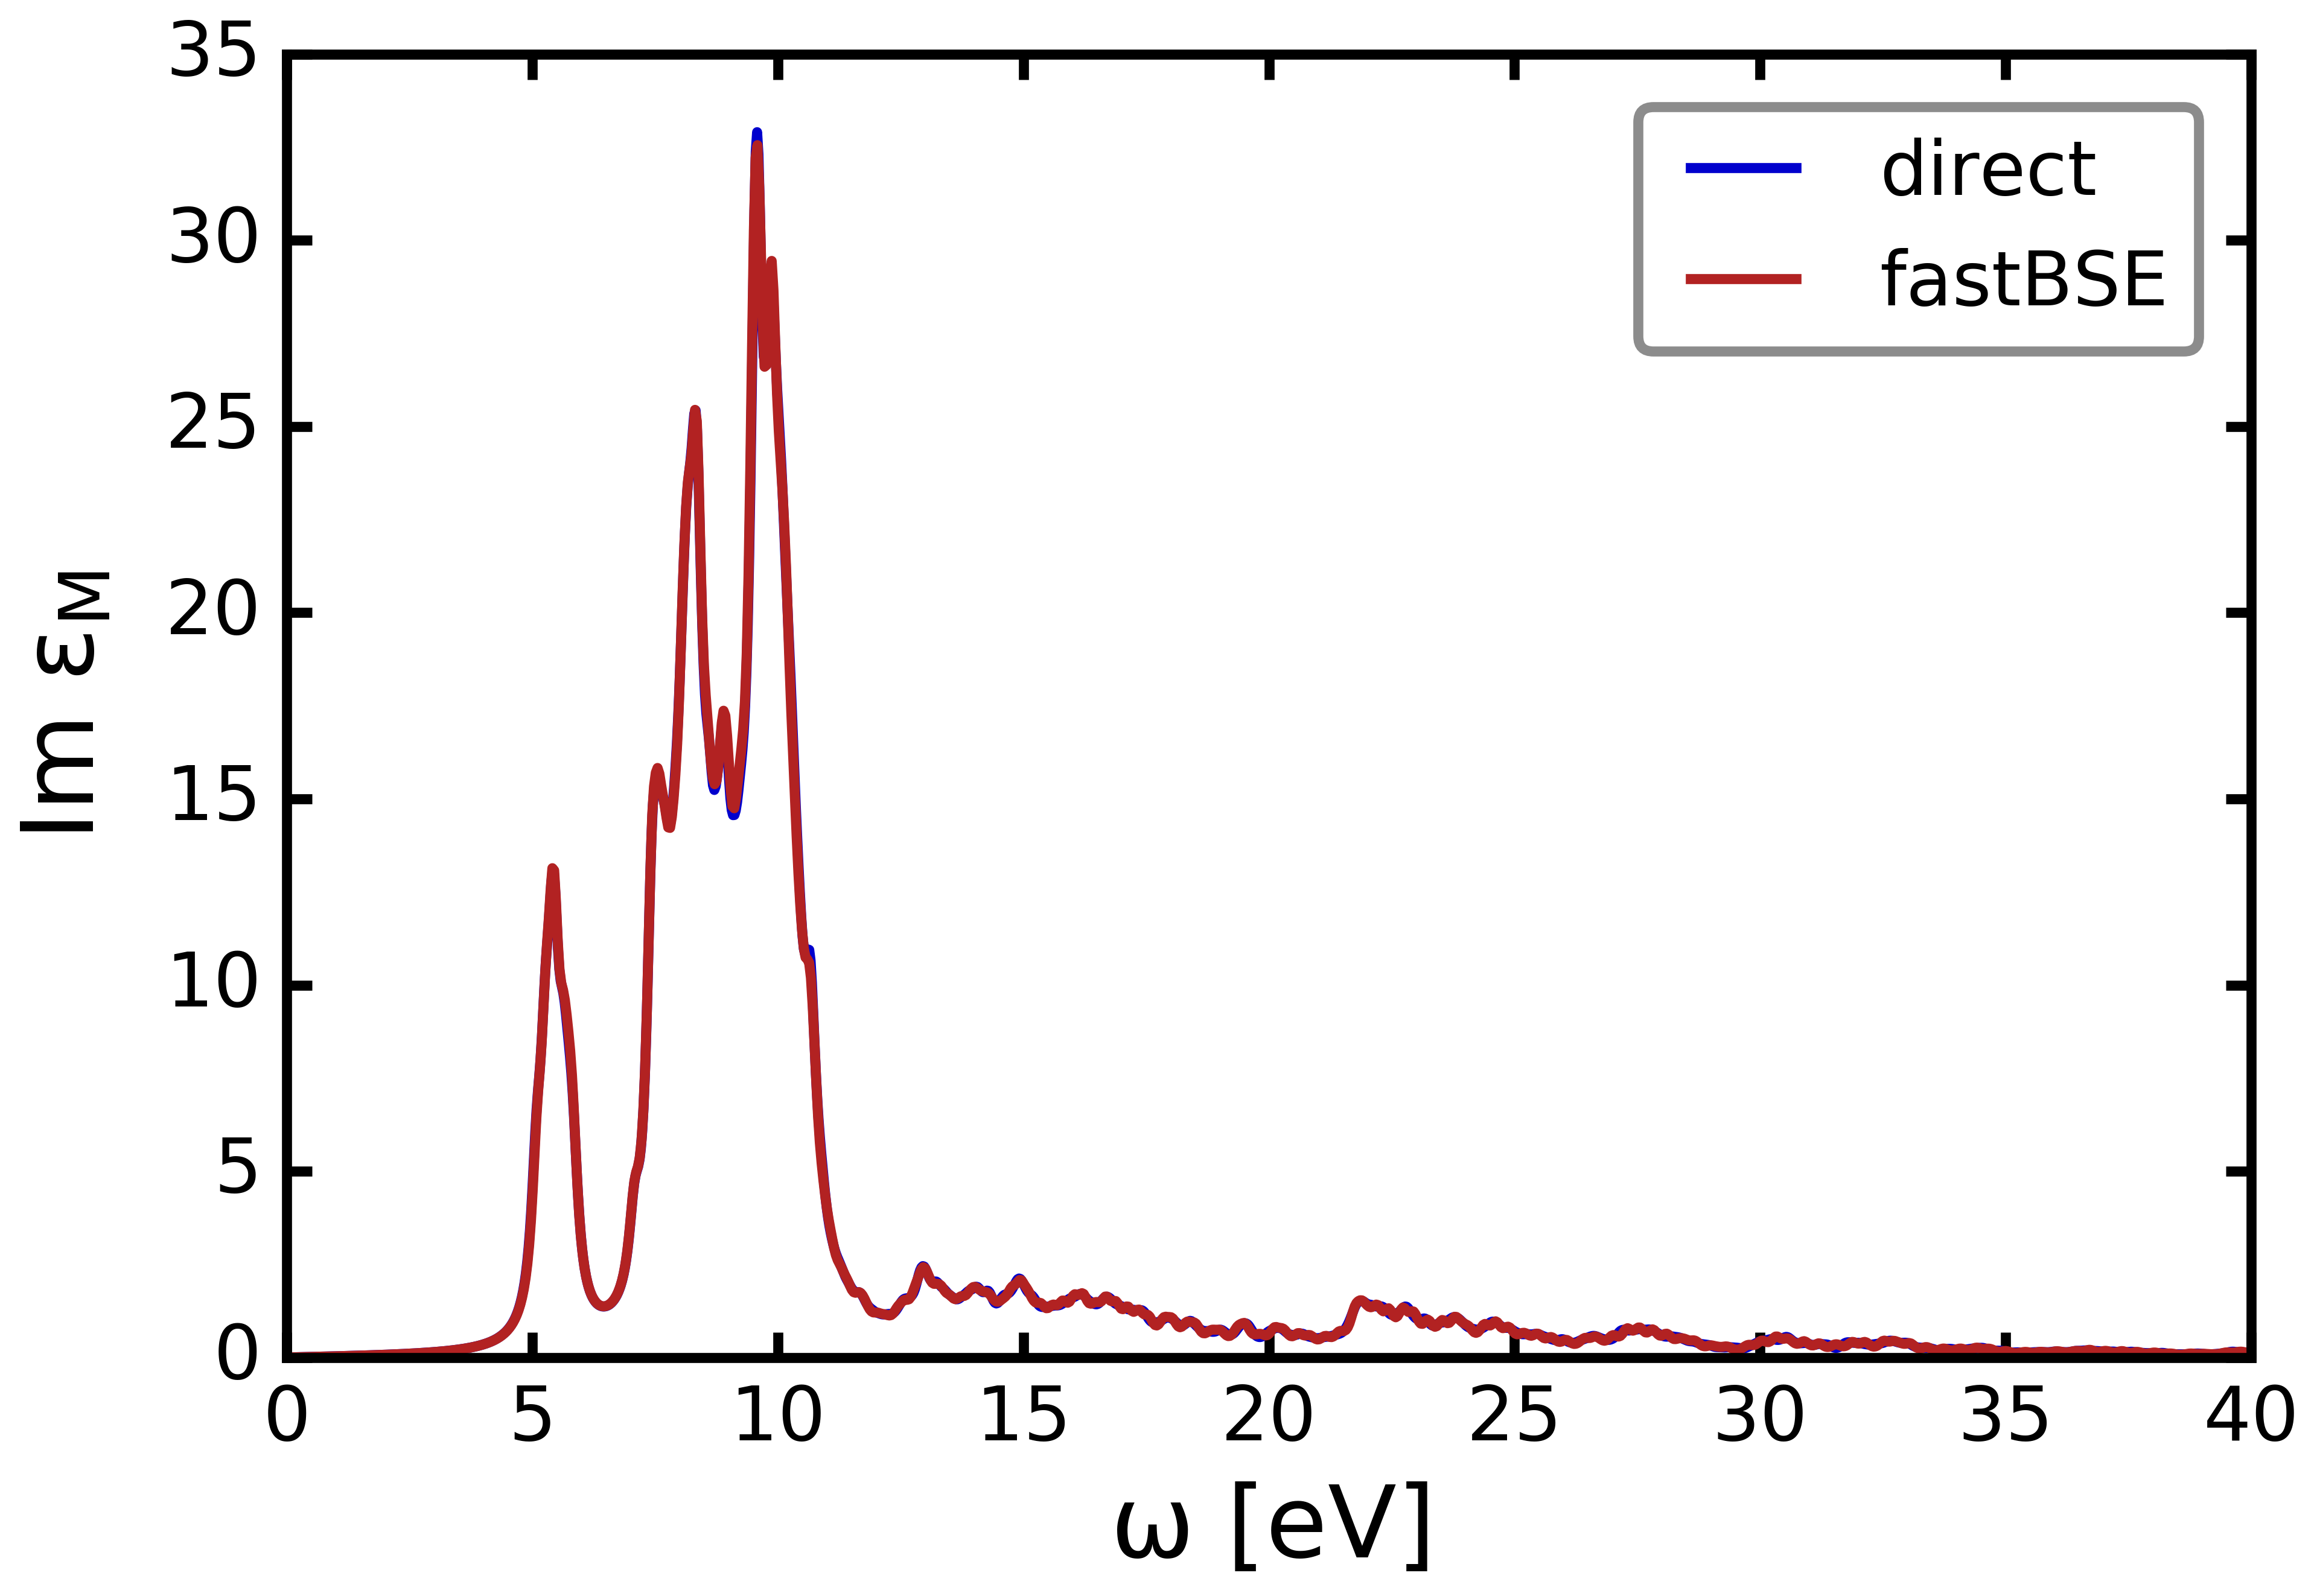" width="500" align="left"/>
</figure>

In [ ]:
%%bash
    